# Planar data classification with one hidden layer

### Importing necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
%matplotlib inline
np.random.seed(1) # setting up a seed so that we get consistent results - comment this and 2 more such lines out in cells 14,20 if you want different results each time

### Building initial functions

In [2]:
def plot_decision_boundary(model,X,y):
    # setting minimum and maximum values (and providing some padding)
    x_min, x_max = X[0,:].min() - 1, X[0,:].max() + 1
    y_min, y_max = X[1,:].min() - 1, X[1,:].max() + 1
    h = 0.01
    # generating a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min,x_max,h), np.arange(y_min,y_max,h))
    # predicting the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # plotting the contour and training examples
    plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0,:], X[1,:], c=y, cmap = plt.cm.Spectral)

In [3]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

In [4]:
# function for generating the dataset we will work with
def load_planar_dataset():
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row contains a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # (maximun ray of the flower)
    
    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta (angle in radians)
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
    
    X = X.T
    Y = Y.T
    
    return X, Y

### Loading our dataset (a "flower" 2-class one)

In [5]:
X, Y = load_planar_dataset()

### Visualizing the data

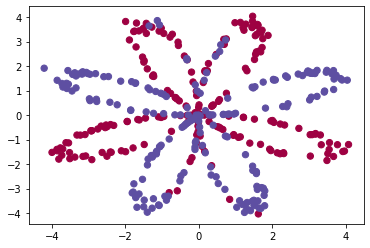

In [6]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

__Note__: The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Our goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

### Getting a better sense of our data (training examples and shape of variables)

We have:
    - a numpy-array (matrix) X that contains our features (x1, x2)
    - a numpy-array (vector) Y that contains our labels (red:0, blue:1)

In [7]:
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]  # training set size

print('The shape of X is: ' + str(shape_X))
print('The shape of Y is: ' + str(shape_Y))
print(f"We have {m} = training examples")

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
We have 400 = training examples


## Simple Logistic Regression

Before building a full neural network, we will check how logistic regression performs on this problem by training a logistic regression classifier on the dataset.

In [8]:
# training the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T.ravel());

Accuracy of logistic regression: 47.0% (percentage of correctly labelled datapoints)


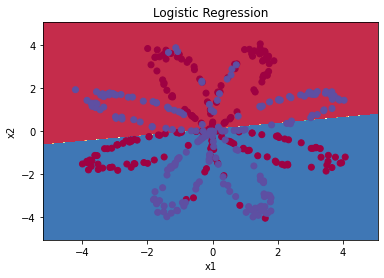

In [9]:
# plotting the decision boundary of the logistic regression model
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# printing the accuracy
LR_predictions = clf.predict(X.T)
print("Accuracy of logistic regression: " + str(float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100)) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Interpretation**: The dataset is not linearly separable, so logistic regression does not perform well on the "flower dataset". We are now going to train a Neural Network with a single hidden layer.

## Neural Network model

### Mathematical description

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}$$

Given the predictions on all the examples, we can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small $$

### General methodology for building a Neural Network
    1. Definition of the neural network's structure ( number of input units, hidden units etc) 
    2. Initialization of the model's parameters
    3. Iterative process (loop):
        - Implementation of forward propagation
        - Loss computation
        - Implementation of backward propagation to calculate the gradients
        - Parameters update (with gradient descent)

We will build helper functions to deal with steps 1-3 and then merge them into a single function that we will use to learn the parameters and then make predictions on new data.

### Defining the neural network structure

In [10]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- labels, of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    return (n_x, n_h, n_y)

### Initializing the model's parameters

In [11]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing our parameters:
                    W1 -- weight matrix, of shape (n_h, n_x)
                    b1 -- bias vector, of shape (n_h, 1)
                    W2 -- weight matrix, of shape (n_y, n_h)
                    b2 -- bias vector, of shape (n_y, 1)
    """
    
    np.random.seed(2) # setting up a seed so our output is not affected by the random initialization
    
    # initializing the weights matrices with random values and the bias vectors as zeros
    
    W1 = np.random.randn(n_h,n_x)*0.01
#     W1 = np.random.randn(layer_sizes(X,Y)[1],layer_sizes(X,Y)[0])*0.01
    b1 = np.zeros((n_h,1))
#     b1 = np.zeros((layer_sizes(X,Y)[1],1))
    W2 = np.random.randn(n_y,n_h)*0.01
#     W2 = np.random.randn(layer_sizes(X,Y)[2],layer_sizes(X,Y)[1])*0.01
    b2 = np.zeros((n_y,1))
#     b2 = np.zeros((layer_sizes(X,Y)[2],1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### The Loop (feedforward propagation, cost computation, backprop, parameters update)

**Note**:
We will use the parameters returned from the previous function to implement forward propagation and compute $Z^{[1]}$, $A^{[1]}$, $Z^{[2]}$ and $A^{[2]}$ (the vector of all our predictions on all the examples in the training set).
Values needed for the backpropagation are stored in `cache` (this will be given as an input to the backpropagation function).

In [12]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data, of size (n_x, m)
    parameters -- python dictionary containing our parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # retrieving the parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # implementing forward propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

__Note__: Now that we computed $A^{[2]}$, which contains $a^{[2](i)}$ for every example, we can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small$$

In [13]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- labels vector, of shape (1, number of examples)
    
    Returns:
    cost -- cross-entropy cost
    
    """
    
    m = Y.shape[1] # number of examples

    # computation of the cross-entropy cost
    logprobs = np.dot(Y,np.log(A2).T) + np.dot((1-Y),np.log(1-A2).T)
    cost = -1/m * logprobs
#     # OR
#     logprobs = np.multiply(Y,np.log(A2)) + np.multiply((1-Y),np.log(1-A2))
#     cost = -1/m * np.sum(logprobs)
    
    cost = float(np.squeeze(cost))  # removes redundant dimensions, so that cost has the expected dimension

    assert(isinstance(cost, float))
    
    return cost

__Note__: We will now implement backward propagation using the cache computed during forward propagation.

The following six equations are necessary for calculating the gradients during backpropagation:

$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

__Hints__: 
- $*$ denotes elementwise multiplication
- We used the following notation:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
- To compute dZ1 we need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$.

In [14]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implements the backward propagation
    
    Arguments:
    parameters -- python dictionary containing the parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    X -- input data, of shape (2, number of examples)
    Y -- labels vector, of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing the gradients with respect to different parameters
    """
    m = X.shape[1]
    
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    A1 = cache.get('A1')
    A2 = cache['A2']
    
    # backward propagation (calculation of dW1, db1, dW2, db2)
    dZ2 = A2 - Y
    dW2 = 1/m * np.dot(dZ2,A1.T)
    db2 = 1/m * np.sum(dZ2,axis=1,keepdims=True)
    dZ1 = np.dot(W2.T,dZ2) * (1 - np.power(A1,2))
    dW1 = 1/m * np.dot(dZ1,X.T)
    db1 = 1/m * np.sum(dZ1,axis=1,keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

__Note__: We will now implement the update rule using gradient descent. We need to use dW1, db1, dW2, db2 in order to update W1, b1, W2, b2 respectively.

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$, where $\alpha$ is the learning rate and $\theta$ represents a parameter.

In [15]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates the parameters using the gradient descent update rule
    
    Arguments:
    parameters -- python dictionary containing the parameters 
    grads -- python dictionary containing the gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # retrieving the parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters.get('W2')
    b2 = parameters['b2']
    
    # retrieving the gradients
    dW1 = grads.get('dW1')
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads.get('db2')
    
    # update rule
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### Merging all functions into one model

In [16]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset, of shape (2, number of examples)
    Y -- labels, of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, the cost is printed every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model, they can be used to predict
    """
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # initializing parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # forward propagation
        A2, cache = forward_propagation(X,parameters)
        
        # cost function
        cost = compute_cost(A2, Y)
 
        # backpropagation
        grads = backward_propagation(parameters, cache, X, Y)
 
        # gradient descent parameter update
        parameters = update_parameters(parameters, grads)
        
        # printing the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print(f"Cost after iteration {i}: {cost}")

    return parameters

### Predictions

**Note**: At this point we will use our model to predict results (via the forward propagation). The following logic will be utilised for the predictions:

predictions: $y_{prediction} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$

In [17]:
def predict(parameters, X):
    """
    Predicts a class for each example in X (using the learned parameters)
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data, of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # computing probabilities using forward propagation, and classifying to 0/1 using 0.5 as the threshold
    A2, cache = forward_propagation(X, parameters)
    predictions = np.where(A2>0.5, 1, 0)
    
    return predictions

### Running the model
__Note__: We will now run the model and see how it performs on a planar dataset. We will test the model with a single hidden layer of $n_h$ hidden units.

Cost after iteration 0: 0.6930480201239823
Cost after iteration 1000: 0.2880832935690184
Cost after iteration 2000: 0.25438549407324546
Cost after iteration 3000: 0.23386415038952205
Cost after iteration 4000: 0.2267924874485401
Cost after iteration 5000: 0.22264427549299015
Cost after iteration 6000: 0.21973140404281316
Cost after iteration 7000: 0.21750365405131297
Cost after iteration 8000: 0.21952171591520497
Cost after iteration 9000: 0.21862544094427414
Cost after iteration 10000: 0.21791028951663172


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

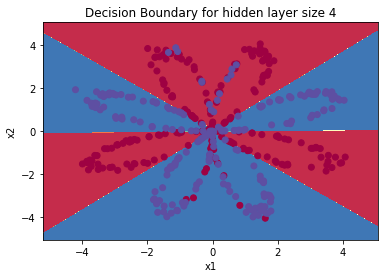

In [18]:
# building a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10001, print_cost=True)

# plotting the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [19]:
# printing the accuracy
predictions = predict(parameters, X)
print('Accuracy: ' + str(float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)) + '%')

Accuracy: 90.75%


__Note__: The accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 

### Tuning the hidden layer size

__Note__: We will observe different behaviors of the model for various hidden layer sizes.

Accuracy for 1 hidden units: 67.5%
Accuracy for 2 hidden units: 67.25%
Accuracy for 3 hidden units: 90.75%
Accuracy for 4 hidden units: 90.5%
Accuracy for 5 hidden units: 91.25%
Accuracy for 20 hidden units: 90.0%
Accuracy for 50 hidden units: 90.75%


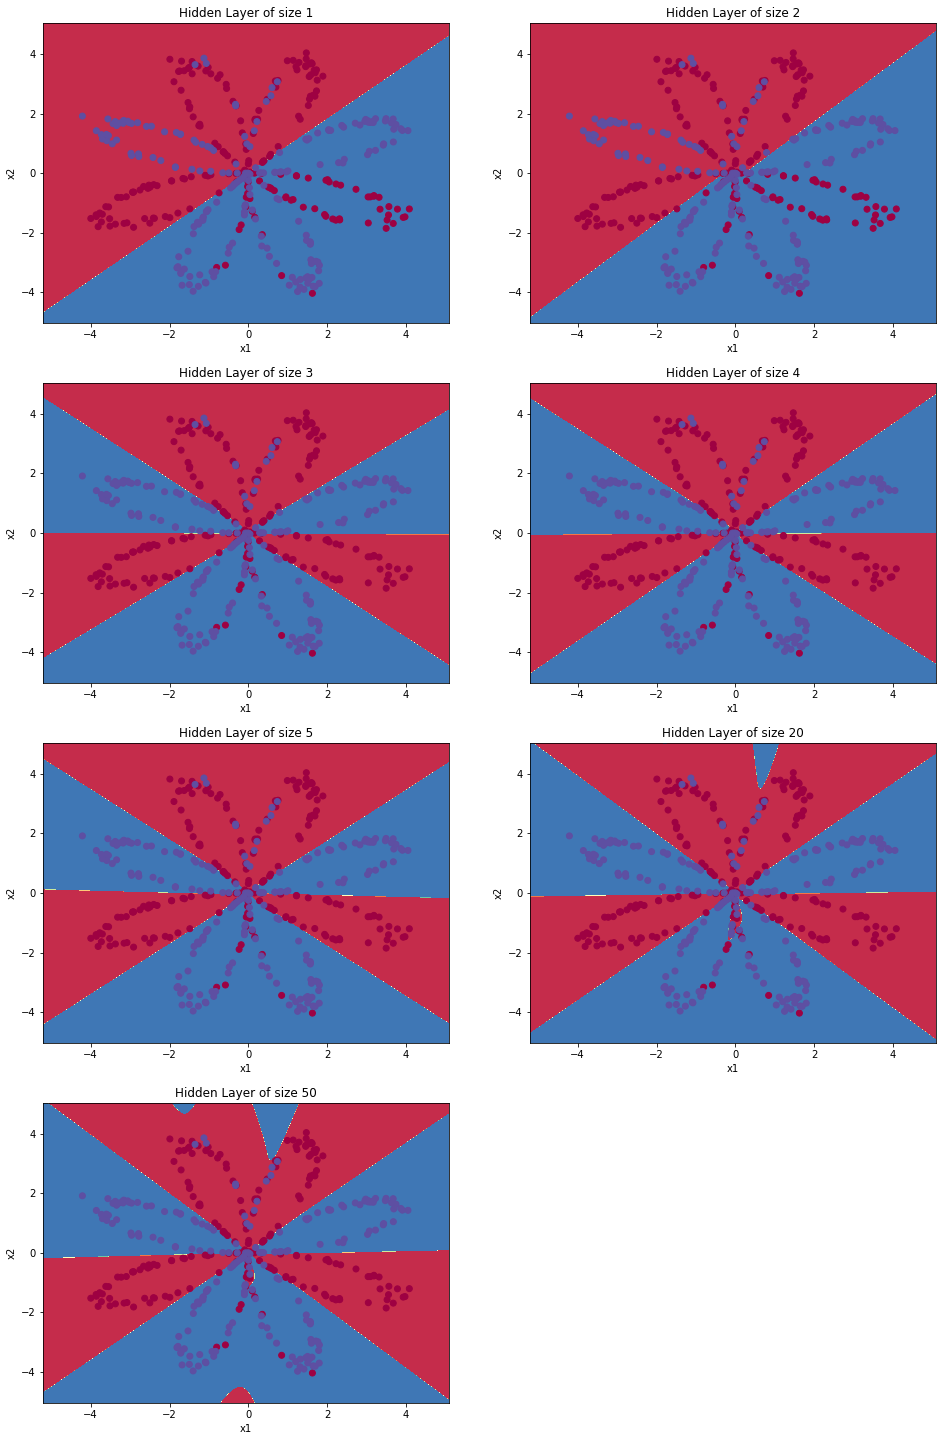

In [20]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title(f"Hidden Layer of size {n_h}")
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print(f"Accuracy for {n_h} hidden units: {accuracy}%")

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually they overfit the data. 
- The best hidden layer size seems to be around n_h = 5, as such a value seems to fit the data well, without also incurring noticeable overfitting.
- We can even use very large models (e.g. with n_h = 50) without much overfitting, by employing regularization.

## Performance on other datasets
We can rerun the whole notebook (minus the dataset part) for each of the following datasets.

In [21]:
# function for generating various datasets
def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples = N, factor = .5, noise = .3)
    noisy_moons = sklearn.datasets.make_moons(n_samples = N, noise = .2)
    blobs = sklearn.datasets.make_blobs(n_samples = N, random_state = 5, n_features = 2, centers = 6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(n_samples = N, n_features = 2,
                  n_classes = 2, mean = None, cov = 0.5, shuffle = True, random_state = None)
    no_structure = np.random.rand(N,2), np.random.rand(N,2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

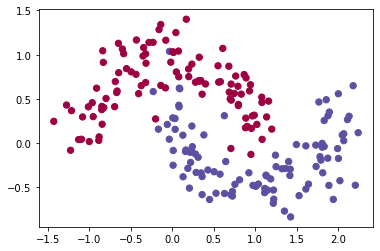

In [22]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# choosing a dataset
dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# making blobs binary
if dataset == "blobs":
    Y = Y%2

# visualizing the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);